**Graphical visualization of current owl ontology:**

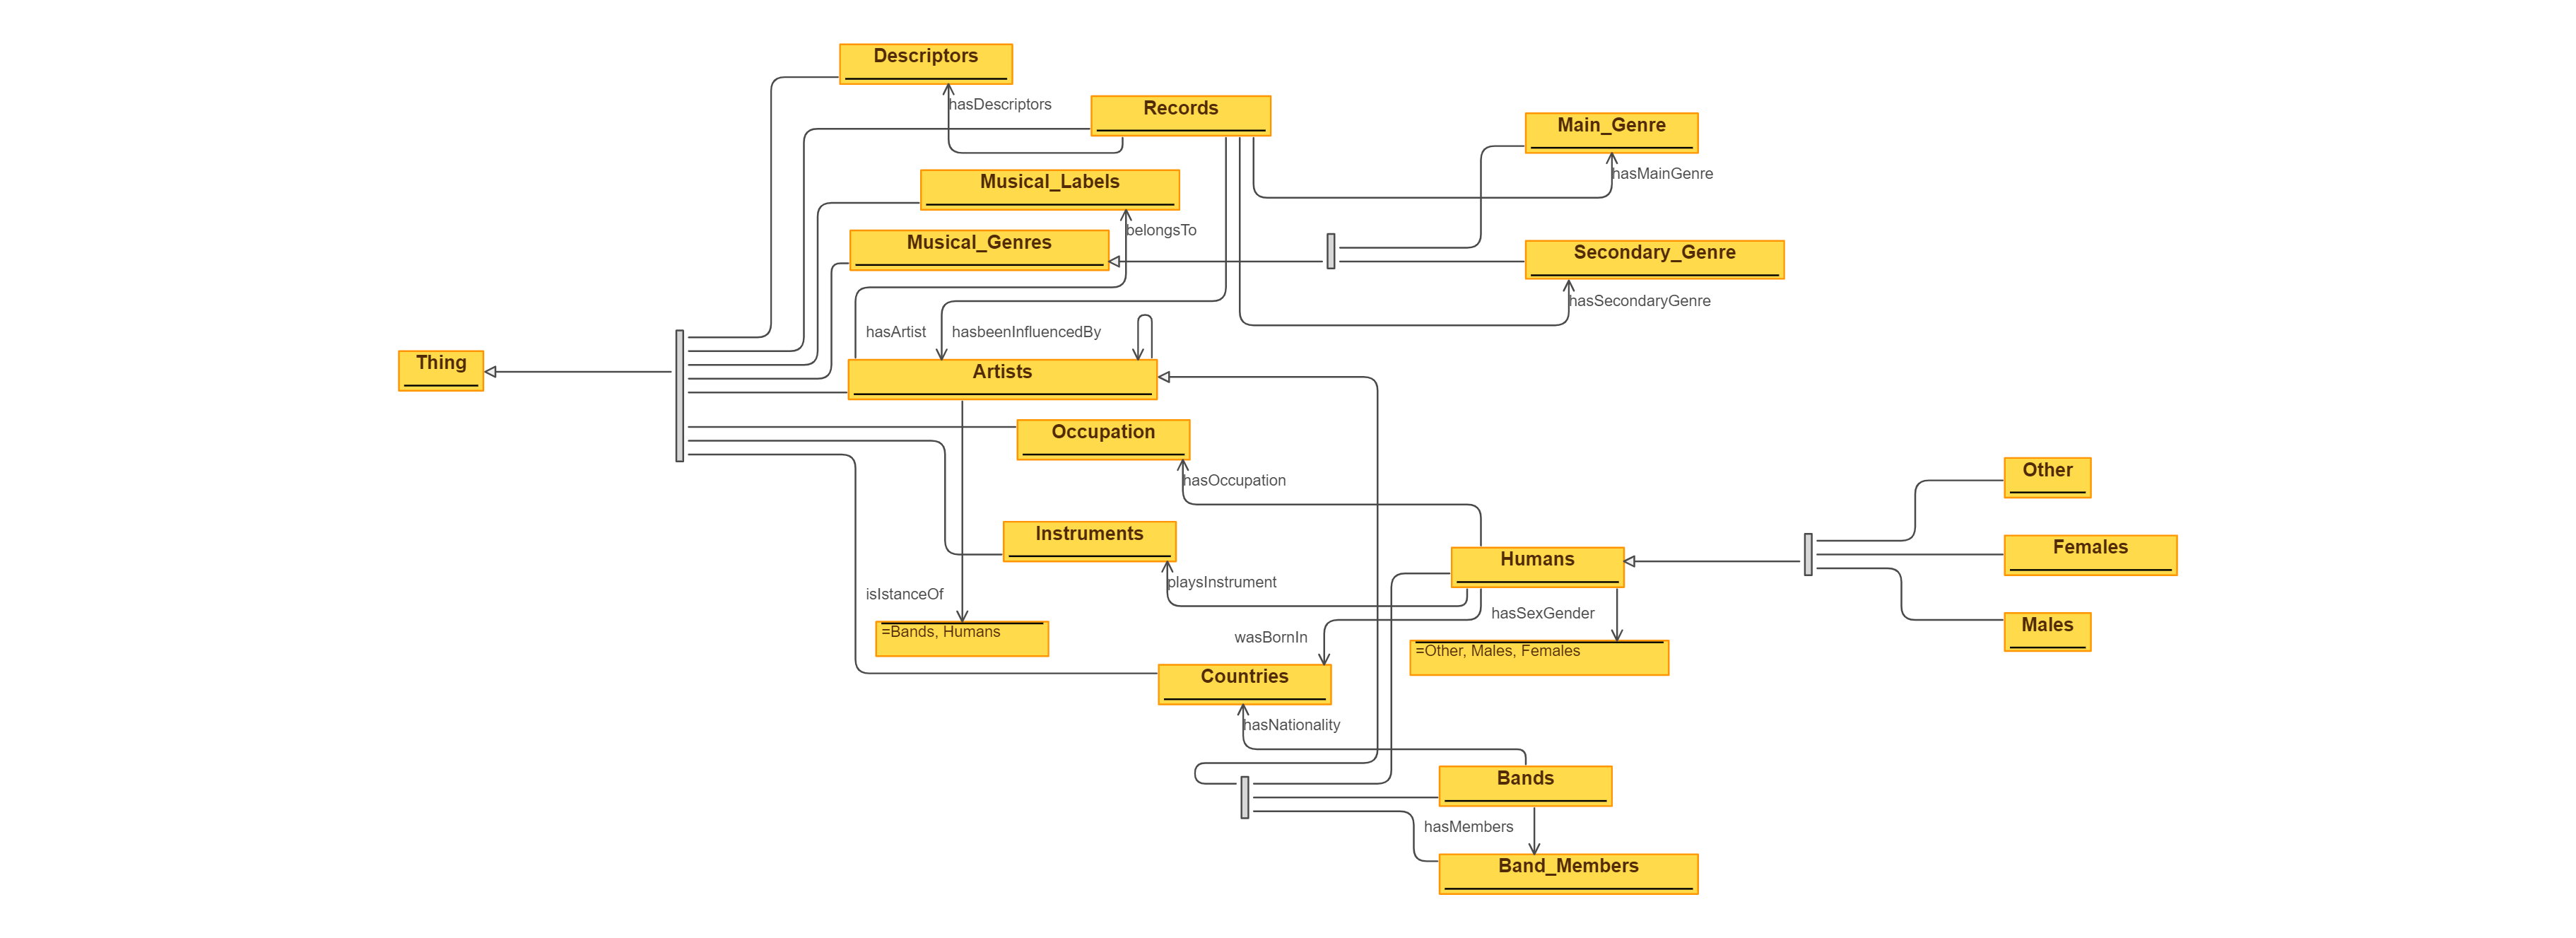

In [ ]:
%%capture
!pip install sparqlwrapper
!pip install rdflib

In [ ]:
import csv
import json
import pandas as pd
import re
import rdflib
from rdflib import URIRef, BNode, Literal, Graph
from rdflib.namespace import CSVW, DC, DCAT, DCTERMS, DOAP, FOAF, ODRL2, ORG, OWL, \
                           PROF, PROV, RDF, RDFS, SDO, SH, SKOS, SOSA, SSN, TIME, \
                           VOID, XMLNS, XSD
from rdflib import Namespace
from rdflib.plugin import register, Serializer
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as plt
import ast


In [ ]:
#merge the partial datasets
result=[]
csv = ["dataset.csv", "2020s.csv", "2010s.csv", "2000s.csv", "1990s.csv", "1980s.csv", "1970s.csv", "1960s.csv", "1950s.csv"]
for a in csv:
  with open(a, 'r', encoding="utf-8") as f:
    line = f.readline()
    while line:
      line_json = json.loads(line)
      line = f.readline()
      result.append(line_json)

with open("dataset_decades.json", "w") as outfile: 
    json.dump(result, outfile)    




In [ ]:
#get wd entries
df_rym = pd.read_json('dataset_decades.json')
df_rym = df_rym.drop_duplicates(subset ="titolo")
df_wd_band = pd.read_csv('wikidata band.csv')
df_wd_human = pd.read_csv('wikidata artist.csv')

index_pos = []
eliminare = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8", "Q9"]
for index, row in df_wd_band.iterrows():
  for a in eliminare:
    if a in row["bandLabel"]:
      index_pos.append(index)

df_wd_band = df_wd_band.drop(index_pos)

index_pos = []
for index, row in df_wd_human.iterrows():
  for a in eliminare:
    if a in row["humanLabel"]:
      index_pos.append(index)

df_wd_human = df_wd_human.drop(index_pos)

#df_rym = df_rym.head(15)

for index, row in df_rym.iterrows():
    artista = row["artist"]
    for r in df_wd_human.itertuples():
        if r[2] == artista:
            df_rym.loc[index, 'Wikidata entry'] = r[1]
            break
    for r in df_wd_band.itertuples():
        if r[2] == artista:
            df_rym.loc[index, 'Wikidata entry'] = r[1]
            break

data = df_rym.drop(columns=["rymURL", "artURL", "cover", "mediaLinks", "avg", "ratings", "reviews"])

#data.to_excel('Dataset Wikidata.xlsx', index=False)
data.to_csv('Dataset_Wikidata_Decades.csv', index=False)

#print(len(index_pos))
#print(index_pos)


In [ ]:
def get_final_query(band):
  data_query = get_results("https://query.wikidata.org/sparql", "", band)

  labels=[]
  countries=[]
  influences=[]
  members = []
  occupations = []
  tipo = ""
  birth = []
  sex = []
  instrument = []
  final_dict = dict()
  for result in data_query["results"]["bindings"]:
    if result["wdLabel"]["value"] == "record label":
      labels.append(result["ps_Label"]["value"])
    elif result["wdLabel"]["value"] == "country of origin":
      countries.append(result["ps_Label"]["value"])
    elif result["wdLabel"]["value"] == "has part":
      members.append(result["ps_Label"]["value"])
    elif result["wdLabel"]["value"] == "influenced by":
      influences.append(result["ps_Label"]["value"])
    elif result["wdLabel"]["value"] == "instance of":
      tipo = result["ps_Label"]["value"]
    elif result["wdLabel"]["value"] == "occupation":
      occupations.append(result["ps_Label"]["value"])
    elif result["wdLabel"]["value"] == "place of birth":
      birth.append(result["ps_Label"]["value"])
    elif result["wdLabel"]["value"] == "sex or gender":
      sex.append(result["ps_Label"]["value"])
    elif result["wdLabel"]["value"] == "instrument":
      instrument.append(result["ps_Label"]["value"])      
    final_dict[band] = {}
    final_dict[band]["tipo"] = tipo
    final_dict[band]["record label"] = labels
    final_dict[band]["country of origin"] = countries
    final_dict[band]["has member"] = members
    final_dict[band]["influenced by"] = influences
    final_dict[band]["occupations"] = occupations
    final_dict[band]["place of birth"] = birth
    final_dict[band]["sex or gender"] = sex
    final_dict[band]["instrument"] = instrument



  return final_dict

In [ ]:
import sys
import re
from SPARQLWrapper import SPARQLWrapper, JSON


def get_results(endpoint_url, query, band):
  endpoint_url = "https://query.wikidata.org/sparql"

  q = "wd:"+band

  query = """SELECT ?wdLabel ?ps_Label ?wdpqLabel ?pq_Label {
    VALUES (?band) {(change_needed)}
    
    ?band ?p ?statement .
    ?statement ?ps ?ps_ .
    
    ?wd wikibase:claim ?p.
    ?wd wikibase:statementProperty ?ps.
    
    OPTIONAL {
    ?statement ?pq ?pq_ .
    ?wdpq wikibase:qualifier ?pq .
    }
    
    SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
  } ORDER BY ?wd ?statement ?ps_"""
  query = query.replace("change_needed", q)
  user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
  # TODO adjust user agent; see https://w.wiki/CX6
  sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
  sparql.setQuery(query)
  sparql.setReturnFormat(JSON)
  return sparql.query().convert()





In [ ]:
my = Namespace("http://www.kraeontology.org/myrym/")   
wd = Namespace("http://www.wikidata.org/entity/")
dataset = pd.read_csv('Dataset_Wikidata_Decades.csv')
g = Graph() 
g.bind("myrym", my) 
g.bind("wd", wd) 

segnibrutti= ["{","}", "®","º", " ", "&", ",", "$", "'", "/", "|","(", ")", "!", "?", "=", 
              ":", ".", "...", "[", "]", "'", "…", "<", ">", "≤>", "\"", "*", "+", "#", "°", ";", "%", "^","_", "▲", "\\", "`"]
for row in dataset.itertuples():
  title = row[1]
  artist =row[2]
  pub_date = row[3]
  genres_list = row[4]
  genres_list = ast.literal_eval(genres_list)
  sec_genres_list=row[5]
  sec_genres_list = ast.literal_eval(sec_genres_list)
  descriptors_list = row[6]
  descriptors_list = ast.literal_eval(descriptors_list)
  wd_entry = row[7]
  if isinstance(wd_entry, str):
    wd_entry = wd_entry.split("/")
    wd_info = get_final_query(wd_entry[-1])
    record_label = wd_info[wd_entry[-1]]["record label"]
    countries = wd_info[wd_entry[-1]]["country of origin"]
    members_list = wd_info[wd_entry[-1]]["has member"]
    influences_list = wd_info[wd_entry[-1]]["influenced by"]
    tipo = wd_info[wd_entry[-1]]["tipo"]
    birth = wd_info[wd_entry[-1]]["place of birth"]
    instrument = wd_info[wd_entry[-1]]["instrument"]
    sex = wd_info[wd_entry[-1]]["sex or gender"]
    occupations = wd_info[wd_entry[-1]]["occupations"]
  for s in segnibrutti:
    title = title.replace(s, "-")
    if len(title) > 2:
      if title[0] == "-":
        title = title[1:]
      if title[-1] == "-":
        title = title[:-1]
    else:
      title = "Untitled"
    artist = artist.replace(s, "-")
    if len(artist) > 2:
      if artist[0] == "-":
        artist = artist[1:]
      if artist[-1] == "-":
        artist = artist[:-1]
    else:
      artist = "Unknown"
    if isinstance(pub_date, str):
      pub_date = pub_date.replace(s, "-")
    else:
      pub_date = ""
    tipo = tipo.replace(s, "-")
  artist=re.sub("-{2,5}", "-", artist)
  title=re.sub("-{2,5}", "-", title)
  g.add((URIRef("http://www.kraeontology.org/myrym/"+title), my.hasArtist, URIRef("http://www.kraeontology.org/myrym/"+artist)))
  g.add((URIRef("http://www.kraeontology.org/myrym/"+title), my.hasPublicationDate, URIRef("http://www.kraeontology.org/myrym/"+pub_date)))
  g.add((URIRef("http://www.kraeontology.org/myrym/"+artist), my.isIstanceOf, URIRef("http://www.kraeontology.org/myrym/"+tipo)))
  if isinstance(row[7], str):
    g.add((URIRef("http://www.kraeontology.org/myrym/"+artist), wd.hasWDEntry, URIRef(row[7])))
  for i in range(len(occupations)):
    occupation = occupations[i]
    for s in segnibrutti:
      occupation= occupation.replace(s, "-")
    occupation=re.sub("-{2,5}", "-", occupation)  
    g.add((URIRef("http://www.kraeontology.org/myrym/"+artist), my.hasOccupation, URIRef("http://www.kraeontology.org/myrym/"+occupation)))
  for i in range(len(sex)):
    sex_gender = sex[i]
    for s in segnibrutti:
      sex_gender= sex_gender.replace(s, "-")
    sex_gender=re.sub("-{2,5}", "-", sex_gender)  
    g.add((URIRef("http://www.kraeontology.org/myrym/"+artist), my.hasSexorGender, URIRef("http://www.kraeontology.org/myrym/"+sex_gender)))
  for i in range(len(instrument)):
    use_instrument = instrument[i]
    for s in segnibrutti:
      use_instrument= use_instrument.replace(s, "-")
    use_instrument=re.sub("-{2,5}", "-", use_instrument)  
    g.add((URIRef("http://www.kraeontology.org/myrym/"+artist), my.hasInstrumentSkill, URIRef("http://www.kraeontology.org/myrym/"+use_instrument)))
  for i in range(len(birth)):
    place_of_birth = birth[i]
    for s in segnibrutti:
      place_of_birth= place_of_birth.replace(s, "-")
    place_of_birth=re.sub("-{2,5}", "-", place_of_birth)  
    g.add((URIRef("http://www.kraeontology.org/myrym/"+artist), my.wasBornIn, URIRef("http://www.kraeontology.org/myrym/"+place_of_birth)))
  for i in range(len(record_label)):
    label = record_label[i]
    for s in segnibrutti:
      label= label.replace(s, "-")
    label=re.sub("-{2,5}", "-", label)  
    g.add((URIRef("http://www.kraeontology.org/myrym/"+artist), my.belongstoLabel, URIRef("http://www.kraeontology.org/myrym/"+label)))
  for i in range(len(countries)):
    country = countries[i]
    for s in segnibrutti:
      country= country.replace(s, "-")
    country=re.sub("-{2,5}", "-", country)  
    g.add((URIRef("http://www.kraeontology.org/myrym/"+artist), my.isFrom, URIRef("http://www.kraeontology.org/myrym/"+country)))
  for i in range(len(members_list)):
    member = members_list[i]
    for s in segnibrutti:
      member= member.replace(s, "-")
    member=re.sub("-{2,5}", "-", member)  
    g.add((URIRef("http://www.kraeontology.org/myrym/"+artist), my.hasMember, URIRef("http://www.kraeontology.org/myrym/"+member)))  
  for i in range(len(influences_list)):
    influence = influences_list[i]
    for s in segnibrutti:
      influence= influence.replace(s, "-")
    influence=re.sub("-{2,5}", "-", influence)  
    g.add((URIRef("http://www.kraeontology.org/myrym/"+artist), my.wasInfluencedBy, URIRef("http://www.kraeontology.org/myrym/"+influence)))     
  for i in range(len(genres_list)):
    main_genre = genres_list[i]
    for s in segnibrutti:
      main_genre= main_genre.replace(s, "-")
    main_genre=re.sub("-{2,5}", "-", main_genre)
    g.add((URIRef("http://www.kraeontology.org/myrym/"+title), my.hasMainGenre, URIRef("http://www.kraeontology.org/myrym/"+main_genre)))
  for i in range(len(sec_genres_list)):
    sec_genre = sec_genres_list[i]
    for s in segnibrutti:
      sec_genre= sec_genre.replace(s, "-")
    sec_genre=re.sub("-{2,5}", "-", sec_genre)
    g.add((URIRef("http://www.kraeontology.org/myrym/"+title), my.hasSecondaryGenre, URIRef("http://www.kraeontology.org/myrym/"+sec_genre)))
  for i in range(len(descriptors_list)):
    descriptor = descriptors_list[i]
    for s in segnibrutti:
      descriptor= descriptor.replace(s, "-")
    descriptor=re.sub("-{2,5}", "-", descriptor)
    if len(descriptor) > 2:
      if descriptor[0] == "-":
        descriptor = descriptor[1:]
      if descriptor[-1] == "-":
        descriptor = descriptor[:-1]
    else:
      descriptor = ""
    g.add((URIRef("http://www.kraeontology.org/myrym/"+title), my.hasDescriptor, URIRef("http://www.kraeontology.org/myrym/"+descriptor)))


g.serialize(destination='final_graph_decades.ttl', format='turtle')






In [ ]:
import rdflib
newg = rdflib.Graph() # we create a new graph

newg.parse("final_graph_decades.ttl", format="ttl") # we insert the graph we have created into the new graph
#below you write your query (right now there is an example of retrieving all the subjects)
querytext = '''
PREFIX per: <http://www.kraeontology.org/myrym/>
SELECT ?s ?p ?o WHERE {?s ?p ?o}
'''
qres = newg.query(querytext) # we create a result file in which there are the results retrieved by the query

qres.serialize(destination='final_decades.csv', format="csv")



In [ ]:
%%capture
!pip install pykeen

In [ ]:
%%capture
from pkg_resources import require
require('pykeen')

In [ ]:
df = pd.read_csv("final_decades.csv", skiprows=[0], header=None)
df

In [ ]:
df = df[df[2] != "http://www.kraeontology.org/myrym/-"]
df

In [ ]:
df.to_csv("final_decades.tsv", sep="\t", index=False, header=False) #pykeen prefers .tsv format

In [ ]:
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
tf = TriplesFactory.from_path("final_decades.tsv")
training, testing = tf.split()
result = pipeline(
    training=training,
    testing=testing,
    model='TransH',
    training_kwargs=dict(num_epochs=1500),  
)
result.save_to_directory('TransH1500')

In [ ]:
import pykeen
import torch
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline


model = torch.load('trained_model.pkl')


In [ ]:
print(model.triples_factory)

TriplesFactory(num_entities=44236, num_relations=15, num_triples=216760, inverse_triples=False, path="/content/final_decades.tsv")


In [ ]:
result.model

TransH(
  (loss): MarginRankingLoss()
  (regularizer): TransHRegularizer()
  (entity_embeddings): Embedding(
    (_embeddings): Embedding(44236, 50)
  )
  (relation_embeddings): Embedding(
    (_embeddings): Embedding(15, 50)
  )
  (normal_vector_embeddings): Embedding(
    (_embeddings): Embedding(15, 50)
  )
)

In [ ]:
#pred_has_artist = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Loveless', 'http://www.kraeontology.org/myrym/hasArtist')
pred_has_artist = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Oil-of-Every-Pearl-s-Un-Insides', 'http://www.kraeontology.org/myrym/hasArtist')
pred_main_genre = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Loveless', 'http://www.kraeontology.org/myrym/hasMainGenre')
pred_sec_genre = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Banco-del-Mutuo-Soccorso', 'http://www.kraeontology.org/myrym/hasSecondaryGenre')
pred_date = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Banco-del-Mutuo-Soccorso', 'http://www.kraeontology.org/myrym/hasPublicationDate')
pred_has_descriptor = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Banco-del-Mutuo-Soccorso', 'http://www.kraeontology.org/myrym/hasDescriptor')


pred_type = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Banco-del-Mutuo-Soccorso', 'http://www.kraeontology.org/myrym/isIstanceOf')
#pred_main_genre = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Autobahn', 'http://www.kraeontology.org/myrym/hasMainGenre')
#pred_has_descriptor = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Abbey-Road', 'http://www.kraeontology.org/myrym/hasDescriptor')
pred_band_members= model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Arcade-Fire', 'http://www.kraeontology.org/myrym/hasMember')
#pred_band_members= model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Muse', 'http://www.kraeontology.org/myrym/hasMember')
pred_sex = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Arcade-Fire', 'http://www.kraeontology.org/myrym/hasSexorGender')
#pred_sex = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Kate-Bush', 'http://www.kraeontology.org/myrym/hasSexorGender')
pred_influence = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Arcade-Fire', 'http://www.kraeontology.org/myrym/wasInfluencedBy')
#pred_influence = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/La-Dispute', 'http://www.kraeontology.org/myrym/wasInfluencedBy')
#pred_occupation = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Miles-Davis', 'http://www.kraeontology.org/myrym/hasOccupation')
pred_occupation = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Arcade-Fire', 'http://www.kraeontology.org/myrym/hasOccupation')
pred_origin = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Arcade-Fire', 'http://www.kraeontology.org/myrym/isFrom')
#pred_origin = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Leonard-Cohen', 'http://www.kraeontology.org/myrym/isFrom')
pred_instr = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Arcade-Fire', 'http://www.kraeontology.org/myrym/hasInstrumentSkill')
#pred_instr = model.get_tail_prediction_df('http://www.kraeontology.org/myrym/Jimi-Hendrix', 'http://www.kraeontology.org/myrym/hasInstrumentSkill')
#pred_rel = model.get_relation_prediction_df('http://www.kraeontology.org/myrym/OK-Computer', 'http://www.kraeontology.org/myrym/Radiohead')
#pred_rel = model.get_relation_prediction_df('http://www.kraeontology.org/myrym/King-Crimson', 'http://www.kraeontology.org/myrym/Kate-Bush')
#pred_rel = model.get_relation_prediction_df('http://www.kraeontology.org/myrym/Loveless', 'http://www.kraeontology.org/myrym/Post-Punk')
#pred_rel = model.get_relation_prediction_df('http://www.kraeontology.org/myrym/Frank-Ocean', 'http://www.kraeontology.org/myrym/guitar')



In [ ]:
#pred_rel[:15]
#pred_instr[:15]
#pred_origin[:15]
#pred_occupation[:15]
#pred_influence[:20]
#pred_sex[:5]
#pred_band_members[:20]
#pred_type[:10]

pred_has_artist[:20]
#pred_has_descriptor[:15]
#pred_main_genre[:15]
#pred_sec_genre[:15]
#pred_date[:10]

,tail_id,tail_label,score,in_training
38668,38668,http://www.kraeontology.org/myrym/clipping,-0.238167,False
29834,29834,http://www.kraeontology.org/myrym/SOPHIE,-0.307917,True
11942,11942,http://www.kraeontology.org/myrym/DJ-Sabrina-t...,-0.308837,False
10472,10472,http://www.kraeontology.org/myrym/Chance-デラソウル...,-0.309349,False
7933,7933,http://www.kraeontology.org/myrym/Autechre,-0.309856,False
6385,6385,http://www.kraeontology.org/myrym/Aero-Gros-M,-0.313039,False
24941,24941,http://www.kraeontology.org/myrym/Nanoray,-0.317519,False
12880,12880,http://www.kraeontology.org/myrym/Devon-Hendryx,-0.323076,False
25500,25500,http://www.kraeontology.org/myrym/Nine-Inch-Nails,-0.324200,False
20389,20389,http://www.kraeontology.org/myrym/Kashiwa-Daisuke,-0.330234,False


In [ ]:
top_k_predictions_df[:50]

In [ ]:
%%capture
import nltk
nltk.download(["names",
"stopwords",
"state_union",
"twitter_samples",
"movie_reviews",
"averaged_perceptron_tagger",
"vader_lexicon",
"punkt"])
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer


In [ ]:
def sent_analysis(text):
  sia = SentimentIntensityAnalyzer()
  return sia.polarity_scores(text)



In [ ]:
descriptors_OKPC = "anxious, alienation, suicide, psychedelic, existential, apathetic, depressive, pessimistic, lo-fi, raw, male vocals, sombre, self-hatred, energetic, ecletic, death, concept album, cryptic"
descriptors_Banco = "psychedelic, philosophical, sombre, nature, occult, uncommon time signature, progressive, alienation, space, anxious, poetic, complex, medieval"
descriptors_Adz = " sad, lonely, poetic, melancholic, bittersweet, melodic, ecletic, introspective, nocturnal, playful, existential, quirky, protest, anxious, longing"
descriptors_Loveless = "sad, apathetic, existential, poetic, melancholic, lonely, depressive, anxious, psychedelic, ecletic, bittersweet, introspective, quirky, wall of sound"
descriptors_Loops = "meditative, suspenseful, minimalistic, atonal, sterious, dissonant, atmospheric, sparse, avant-garde, scary, tribal, repetitive, hypnotic, acquatic, microtonal"
descriptors_Oil = " repetitive, futuristic, abstract, nocturnal, mechanical, androgunoys vocals, minimalistic, atmospheric, anxious, ecletic, lo-fi, sampling, LGBT, disturbing"
prova = "mellow, cryptic, eclectic, atmospheric, male vocals, quirky, love, melodic, poetic, lush, warm, bittersweet, abstract, sentimental, melancholic, rhythmic"

In [ ]:
sent_analysis(descriptors_Banco)

{'compound': -0.4767, 'neg': 0.24, 'neu': 0.76, 'pos': 0.0}

In [ ]:
sent_analysis(descriptors_OKPC)

{'compound': -0.9423, 'neg': 0.571, 'neu': 0.346, 'pos': 0.084}

In [ ]:
sent_analysis(descriptors_Adz)

{'compound': -0.7506, 'neg': 0.573, 'neu': 0.302, 'pos': 0.125}

In [ ]:
sent_analysis(descriptors_Loveless)

{'compound': -0.9001, 'neg': 0.625, 'neu': 0.375, 'pos': 0.0}

In [ ]:
sent_analysis(descriptors_Loops)

{'compound': -0.4215, 'neg': 0.265, 'neu': 0.612, 'pos': 0.122}

In [ ]:
sent_analysis(descriptors_Oil)

{'compound': -0.743, 'neg': 0.378, 'neu': 0.622, 'pos': 0.0}

In [ ]:
sent_analysis(prova)

{'compound': 0.7783, 'neg': 0.113, 'neu': 0.522, 'pos': 0.365}